# Classifying Fruits 360 dataset images using ResNets, Regularization and Data Augmentation in PyTorch

This is the final course assignment.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install opendatasets --upgrade


In this project, I'll use the following techniques to train a model to achieve over 99% accuracy in  classifying images from the Fruits 360 dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [4]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [72]:
project_name='final-project-assignment'

## Preparing the Fruits 360 Dataset


![Fruits 360](https://storage.googleapis.com/kaggle-datasets-images/5857/8713/df2a86f4b6ecfff7996be179a4e8ebdf/dataset-cover.jpg?t=2017-12-02-08-49-27)


Download the dataset and create PyTorch datasets to load the datail.

In [6]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

  1%|          | 5.00M/760M [00:00<00:26, 29.7MB/s]

100%|██████████| 760M/760M [00:06<00:00, 129MB/s]


In [7]:
# Look into the data directory
data_dir = './fruits/fruits-360'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/Training')
print(classes)

['Training', 'test-multiple_fruits', 'Test', 'papers', 'readme.md', 'LICENSE']
['Eggplant', 'Apple Pink Lady', 'Tangelo', 'Tomato not Ripened', 'Cucumber Ripe 2', 'Mango Red', 'Cocos', 'Nectarine Flat', 'Grapefruit White', 'Passion Fruit', 'Mulberry', 'Cherry Rainier', 'Apple Braeburn', 'Apple Crimson Snow', 'Pitahaya Red', 'Grape White', 'Pepper Green', 'Quince', 'Limes', 'Physalis', 'Physalis with Husk', 'Potato Red Washed', 'Watermelon', 'Corn Husk', 'Tomato Maroon', 'Apple Red Delicious', 'Mango', 'Onion Red', 'Cantaloupe 1', 'Peach', 'Maracuja', 'Apple Red Yellow 2', 'Pepper Orange', 'Guava', 'Potato White', 'Pineapple Mini', 'Grape White 4', 'Cucumber Ripe', 'Tomato 3', 'Lemon Meyer', 'Carambula', 'Melon Piel de Sapo', 'Strawberry', 'Kohlrabi', 'Grape Blue', 'Onion Red Peeled', 'Raspberry', 'Pear Williams', 'Pineapple', 'Peach Flat', 'Granadilla', 'Kiwi', 'Nut Pecan', 'Avocado', 'Grape White 2', 'Strawberry Wedge', 'Tomato 1', 'Cherry Wax Black', 'Pomelo Sweetie', 'Pear', 'Pepper

In [8]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [9]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/Training', train_tfms)
dataset = ImageFolder(data_dir+'/Test', valid_tfms)

In [10]:
print(len(train_ds))
print(len(dataset))

67692
22688


In [11]:
random_seed = 42
torch.manual_seed(random_seed);

In [12]:
valid_size = 12000
test_size = len(dataset) - valid_size

test_ds, valid_ds = random_split(dataset, [test_size, valid_size])
len(train_ds), len(valid_ds), len(test_ds)

(67692, 12000, 10688)

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 200 to utlize a larger portion of the GPU RAM. You can try reducing the batch size & restarting the kernel if you face an "out of memory" error.

In [13]:
batch_size = 200

In [14]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

Let's take a look at some sample images from the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range (0,1).

In [15]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        #print(images.shape)
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

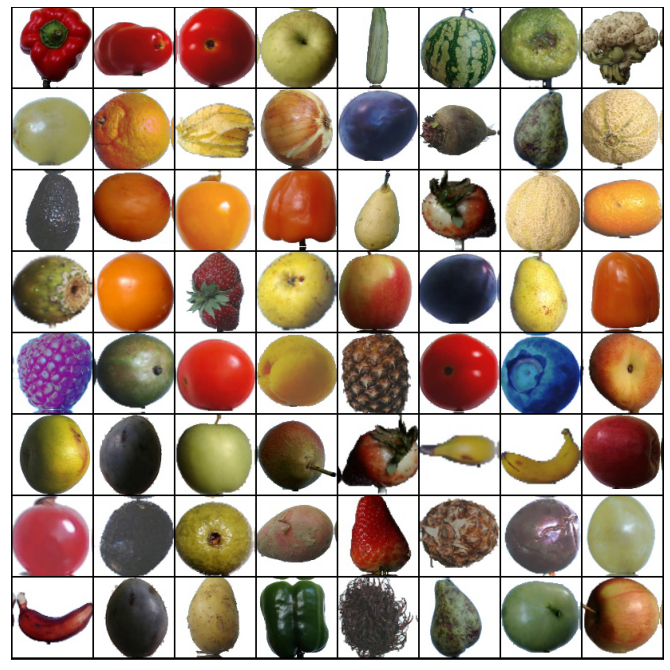

In [16]:
show_batch(train_dl)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [20]:
# count=0
# for images, labels in train_dl:
#     print(images.shape)
#     count+=1
#     if(count==10):
#       break

In [21]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [22]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([200, 3, 100, 100])
torch.Size([200, 3, 100, 100])


In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) # 64 * 100 * 100
        self.conv2 = conv_block(64, 128, pool=True) # 128 * 50 * 50
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 * 25 * 25
        self.conv4 = conv_block(256, 512, pool=True) # 512 * 12 * 12
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 728, pool=True) # 728 * 6 * 6
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), # 728 * 1 * 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(728, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        #print('1', out.shape)
        out = self.conv2(out)
        #print('2', out.shape)
        out = self.res1(out) + out
        #print('3', out.shape)
        out = self.conv3(out)
        #print('4', out.shape)
        out = self.conv4(out)
        #print('5', out.shape)
        out = self.res2(out) + out
        #print('6', out.shape)
        out = self.conv5(out)
        #print('7', out.shape)
        out = self.classifier(out)
        #print('8', out.shape)
        return out

In [25]:
model = to_device(ResNet9(3, 131), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.00866666715592146, 'val_loss': 4.877010345458984}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent/index.html

In [28]:
!pip install jovian --upgrade --quiet

In [29]:
import jovian

In [30]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/arnabbhakta956/final-project-assignment-1


'https://jovian.ai/arnabbhakta956/final-project-assignment-1'

In [31]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 0.5316, val_loss: 0.5256, val_acc: 0.8450
Epoch [1], last_lr: 0.00936, train_loss: 0.1837, val_loss: 0.6150, val_acc: 0.8598
Epoch [2], last_lr: 0.00972, train_loss: 0.0815, val_loss: 0.0928, val_acc: 0.9722
Epoch [3], last_lr: 0.00812, train_loss: 0.0432, val_loss: 0.2634, val_acc: 0.9367
Epoch [4], last_lr: 0.00556, train_loss: 0.0235, val_loss: 0.0533, val_acc: 0.9862
Epoch [5], last_lr: 0.00283, train_loss: 0.0099, val_loss: 0.0265, val_acc: 0.9928
Epoch [6], last_lr: 0.00077, train_loss: 0.0015, val_loss: 0.0242, val_acc: 0.9941
Epoch [7], last_lr: 0.00000, train_loss: 0.0005, val_loss: 0.0184, val_acc: 0.9949
CPU times: user 24min 3s, sys: 23min 5s, total: 47min 9s
Wall time: 47min 18s


In [43]:
train_time='47:18'

In [44]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

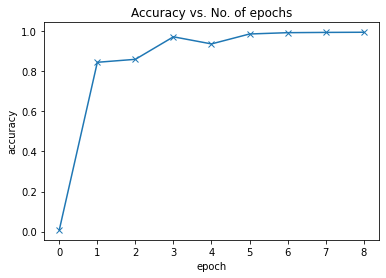

In [45]:
plot_accuracies(history)

In [46]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

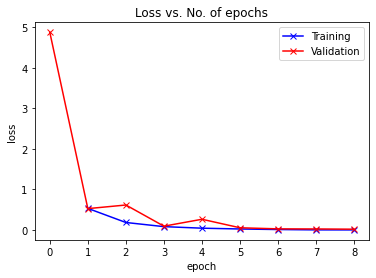

In [47]:
plot_losses(history)

In [48]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

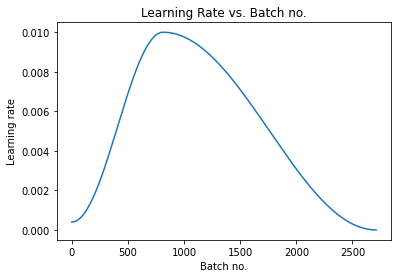

In [49]:
plot_lrs(history)

In [50]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Pepper Yellow , Predicted: Pepper Yellow


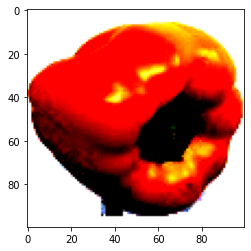

In [51]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Physalis with Husk , Predicted: Physalis with Husk


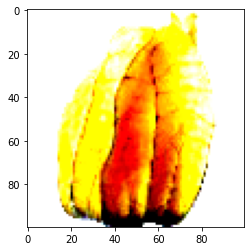

In [56]:
img, label = valid_ds[105]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Cherry Wax Black , Predicted: Cherry Wax Black


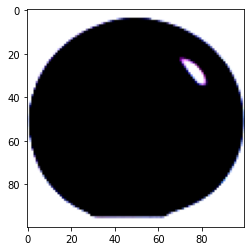

In [57]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [58]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9958332777023315, 'val_loss': 0.01624409295618534}

In [59]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [60]:
torch.save(model.state_dict(), 'fruits-resnet9.pth')

In [61]:
!pip install jovian --upgrade --quiet

In [66]:
import jovian

In [67]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [68]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [71]:
jovian.commit(project=project_name, environment=None, outputs=['fruits-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/arnabbhakta956/final-project-assignment


'https://jovian.ai/arnabbhakta956/final-project-assignment'